Import necessary libraries

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

Load a pre-trained CNN (VGG16) for feature extraction

In [ ]:
model = models.vgg16(pretrained=True).features.eval().to('cuda')

Define image preprocessing function

In [ ]:
def preprocess_image(img_tensor):
    """Convert a tensor to a NumPy image for visualization"""
    img = img_tensor.clone().detach().cpu().numpy()
    img = img.squeeze(0)  # Remove batch dimension
    img = np.transpose(img, (1, 2, 0))  # Convert from CHW to HWC format
    img = np.clip(img, 0, 1)  # Ensure valid pixel range
    return img

Define optimization function

Image Optimization:

    - We start with a blank image (random noise or zeros)
    - Modify it iteratively to maximize the activation of a chosen neuron

In [ ]:
def optimize_image(layer_idx, neuron_idx, steps=50, lr=0.1):
    """Optimize an image to maximize activation of a specific neuron"""
    image = torch.zeros((1, 3, 224, 224), requires_grad=True, device='cuda')
    optimizer = torch.optim.Adam([image], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()
        x = image

        # Forward pass through the model until the selected layer
        for i, layer in enumerate(model):
            x = layer(x)
            if i == layer_idx:  # Stop at the desired layer
                break

        # Compute loss as negative activation of the target neuron
        loss = -x[0, neuron_idx].mean()
        loss.backward()
        optimizer.step()

        # Clip values to keep them in valid range
        image.data.clamp_(0, 1)

    return image

Select a layer and neuron to visualize

    - In CNNs, each layer detects different features (edges, textures, objects)
    - Higher layers detect more complex features
    - We choose a layer and a specific neuron to maximize its activation

Activation Maximization:

    - The goal is to modify the input image so that a specific neuron's activation is maximized
    - We take the mean activation of the layer as the "loss" and perform **gradient ascent**
    
    - Formula:
    L = -mean(activation)
    This ensures that gradient updates **increase** the activation value.

Optimization:

    - We use **Gradient Ascent** (instead of descent) to **increase** activations
    - Adam optimizer is used to update pixel values
    - Formula:
    θ ← θ + η * ∂L/∂θ, where:
        - θ are pixel values
        - η is the learning rate
        - ∂L/∂θ is the gradient

In [ ]:
layer_idx = 17  # Example: Conv Layer in VGG16
neuron_idx = 5   # Example neuron

# Run optimization
optimized_image = optimize_image(layer_idx, neuron_idx, steps=100, lr=0.05)

Display the optimized image

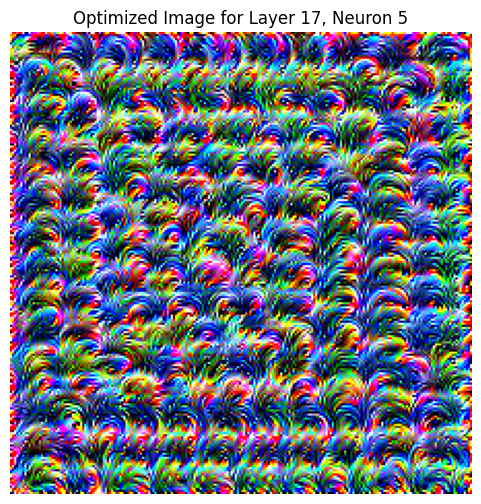

In [ ]:
# Convert tensor to image format
optimized_np = preprocess_image(optimized_image)

# Display the optimized image
plt.figure(figsize=(6,6))
plt.imshow(optimized_np)
plt.axis('off')
plt.title(f'Optimized Image for Layer {layer_idx}, Neuron {neuron_idx}')
plt.show()

Summary of the Code: Optimizing Images to Maximize Neuron Activation in CNN

    This code modifies an input image to maximize the activation of a specific neuron in a CNN (VGG16).
    The goal is to visualize what a neuron has learned by generating an image that strongly activates it.



Outcome:

    The generated image visualizes what a specific CNN neuron has learned.

    Helps understand how deep learning models interpret visual data.